# Electrodynamics of the Equatorial Ionosphere III
#### By Amadi Brians C.
##### bamadi@brianspace.org

In [1]:
#=========== Import Packages =============
    
import os
import glob
import shutil
import matplotlib
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import cartopy.crs as ccrs
from netCDF4 import Dataset 
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import cartopy.feature as cfeature
from netCDF4 import date2num, num2date
import matplotlib.gridspec as gridspec
from IPython.display import Video, display, HTML

import sys
import requests
import datetime
from urllib.parse import quote

#This user-defined package contains instruction for downloading
#download some files from zenodo, necessary to make 
#some plots such as magnetic equator, etc.
sys.path.append("..")  # path to your helper script folder
from utils.zenodo_tools import get_from_zenodo
from utils.get_dependencies import ensure_dependencies

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*get_cmap function was deprecated.*")

In [2]:
#This code downloads the files and packages
#into a folder named dependencies
ensure_dependencies()

✔ convert_waccmx_datesec.py already exists. Skipping download.
✔ sha.py already exists. Skipping download.
✔ igrf13coeffs.txt already exists. Skipping download.
✔ mag2geo_all.csv already exists. Skipping download.


In [3]:
#Import User-defined packages and files downloaded
sys.path.append("..")  # adjust if needed
from dependencies.convert_waccmx_datesec import *   # or import specific functions
import dependencies.sha as sha

In [4]:
# ===== File with WACCM-X EDens =====
wacx = Dataset('../data/WACCMX_subset.nc')

#### A reminder of observed dynamics:
- Recall the following observed dynamics from [Electrodynamics of the Equatorial Ionosphere II](notebooks/Electrodynamics_2.ipynb).
1. Upward (vertical) wind $\implies$ Eastward (zonal) **E** $\implies$ vertical drift
2. Eastward (Zonal) wind $\implies$ Upward (vertical) **E** $\implies$ zonal drift
3. Northward (meridional) wind $\implies$ No **E**

#### Another Dynamics

4. Enhanced $V_{vertical}$

- Plasma in the equatorial ionosphere can drift upwards and downwards depending on the time of the day. This drift is known as vertical drift. 

- Vertical drift is upward during the day but reverses downward postsunset. Before the downward reversal, vertical drift becomes enhanced (increases greatly). This is known as Pre-Reversal enhancement (PRE). As shown in the shaded region of the Figure 4.1.

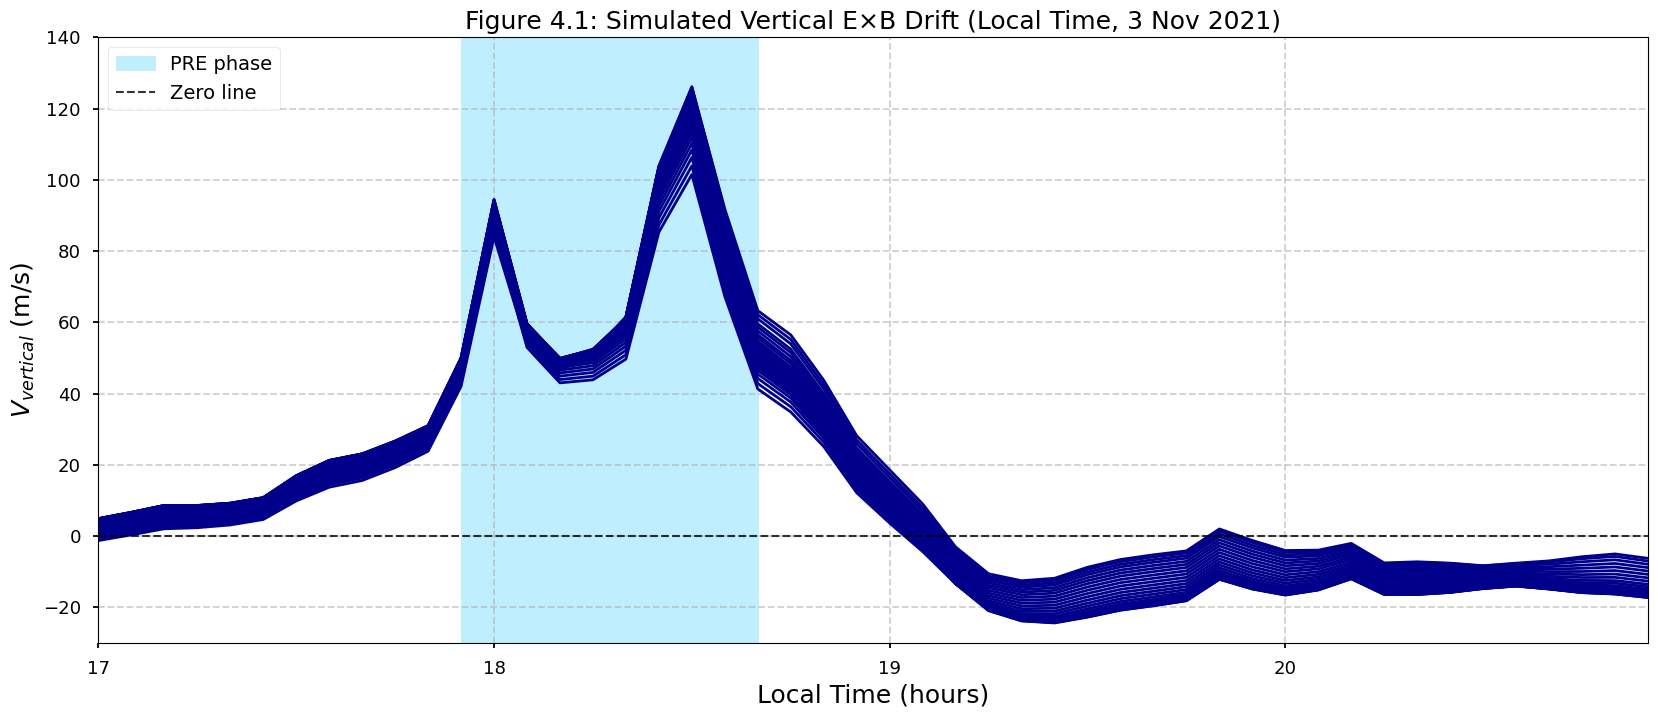

In [7]:
#==================== Data Preparation ====================#

# Convert time variable (assuming your helper functions are defined elsewhere)
variable = wacx['datesec'][:]
wactime = time_conv(variable)
wtime2d = time_2d(wactime)

# Convert 'HH:MM' strings to numeric hours
def convert_to_hours(time_array):
    times = []
    for t in time_array:
        h, m = map(int, t.split(':'))
        times.append(h + m / 60.0)
    return np.array(times)

# Convert wtime2d to numeric hours
wtime2d = convert_to_hours(wtime2d)

# Convert from UT to Local Time (subtract 3 hours)
local_time = wtime2d - 3

# Ensure values wrap correctly (e.g., -1 → 23)
local_time = np.mod(local_time, 24)

#==================== Plot Styling ====================#

plt.style.use('seaborn-v0_8-talk')   # clean scientific style
SMALL_SIZE = 18
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

#==================== Plot Figure ====================#

fig, ax = plt.subplots(figsize=(18, 8))

# Plot the variable (E×B drift velocity or similar)
lat_range = slice(83, 109)
ax.plot(local_time, wacx['WI'][:, 15, lat_range, 265],
        color='darkblue', lw=2)

# Highlight a specific time window (example)
highlight_start = local_time[11]
highlight_end = local_time[20]
ax.axvspan(highlight_start, highlight_end,
           color='deepskyblue', alpha=0.25, label='PRE phase')

#==================== Reference Line at y=0 ====================#
ax.axhline(y=0, color='black', linestyle='--',
           linewidth=1.5, alpha=0.8, label='Zero line')

#==================== Axis Labels & Formatting ====================#

ax.set(
    title='Figure 4.1: Simulated Vertical E×B Drift (Local Time, 3 Nov 2021)',
    xlabel='Local Time (hours)',
    ylabel=r'$V_{vertical}$ (m/s)',
    ylim=(-30, 140),
    xlim=(local_time[0], local_time[-1])
)

# Use consistent ticks
ax.set_xticks(local_time[::12])
ax.grid(True, linestyle='--', alpha=0.6)

# Add text annotations for context
#fig.text(0.75, 0.83, r'Latitude = $\pm 10^\circ$', fontsize=18)
#fig.text(0.75, 0.77, r'Longitude = 38$^\circ$W', fontsize=18)

# Add legend and tighten layout
ax.legend(loc='upper left', fontsize=14)
fig.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])

#==================== Show Plot ====================#
plt.show()


- In plain terms, imagine holding a drift meter while standing on the magnetic equator. You will measure a drift velocity greater than zero during the day and this drift increases greatly after sunset.

#### Source of Enhanced $V_{vertical}$ (PRE)

- From previous conversations in [Electrodynamics of the Equatorial Ionosphere II](notebooks/Electrodynamics_2.ipynb), the zonal electric field **E** is responsible for vertical drift. While upward vertical drift is due to eastward **E**, downward vertical drift is due to westward **E**. This is illustrated in Figure 4.2.

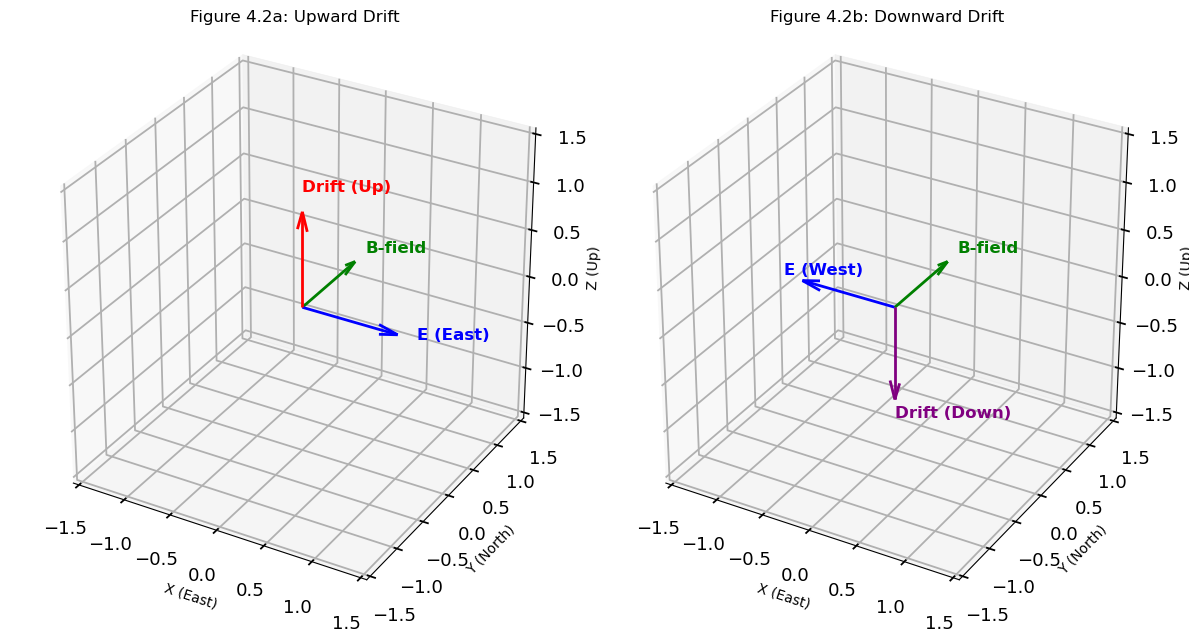

In [33]:
# ========= Direction of E ==========
matplotlib.rc('font', size=10)
fig = plt.figure(figsize=(12, 6))

# ======== Draw vectors =======
def draw_vectors(ax, vectors, colors, labels):
    for (x, y, z), color, label in zip(vectors, colors, labels):
        ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.2, linewidth=2)
        ax.text(x*1.2, y*1.2, z*1.2, label, color=color, fontsize=12, weight='bold')

    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.set_xlabel('X (East)', labelpad=10)
    ax.set_ylabel('Y (North)', labelpad=10)
    ax.set_zlabel('Z (Up)', labelpad=10)
    ax.set_box_aspect([1,1,1])  # Equal aspect

# Case 1: Ohmic E-field (upward)
ax1 = fig.add_subplot(121, projection='3d')
vectors1 = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # u, B, E_ohmic
colors1 = ['blue', 'green', 'red']
labels1 = ['E (East)', 'B-field', 'Drift (Up)']
draw_vectors(ax1, vectors1, colors1, labels1)
ax1.set_title("Figure 4.2a: Upward Drift", fontsize = 12)

# Case 2: Induced E-field (downward)
ax2 = fig.add_subplot(122, projection='3d')
vectors2 = [(-1, 0, 0), (0, 1, 0), (0, 0, -1)]  # u, B, E_induced
colors2 = ['blue', 'green', 'purple']
labels2 = ['E (West)', 'B-field', 'Drift (Down)']
draw_vectors(ax2, vectors2, colors2, labels2)
ax2.set_title("Figure 4.2b: Downward Drift", fontsize = 12)

plt.tight_layout()
plt.show()

- This means that the **enhanced upward vertical drift** at postsunset is due to an enhancement in **eastward E**.

##### So, what is responsible for the enhanced eastward **E** at about sunset? 

- This is due to an additional localized **E** generated via the following process:

    - An eastward wind blowing across the day/night divider (solar terminator), generating a downward **E**.

    - The consequence of this field is a westward current density, **J** as shown in Figure 4.3.


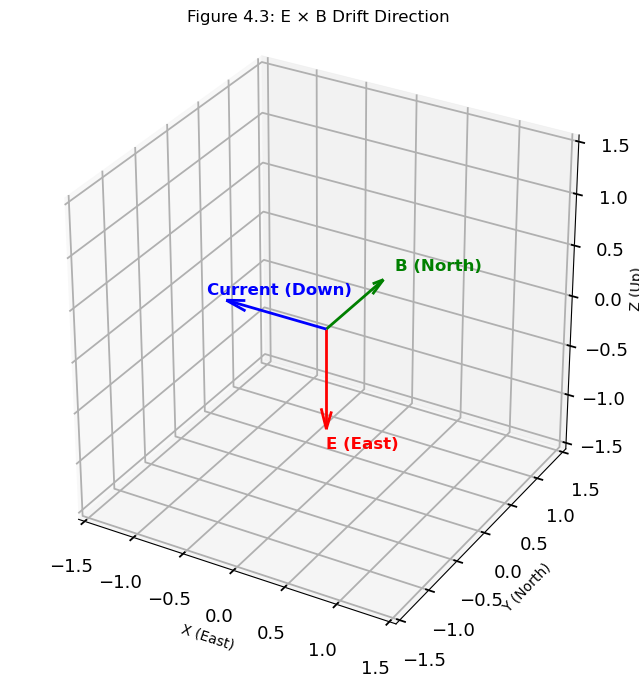

In [34]:
# ======== Plot Direction of Drift Velocity ========

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Define vectors
E = np.array([0, 0, -1])  # downward
B = np.array([0, 1, 0])   # northward
J = -np.cross(E, B)      # Current Density carried by electrons
                          # Hence, the current points west
                          # 
# Function to plot vectors
def plot_vector(ax, vec, color, label):
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
              color=color, arrow_length_ratio=0.2, linewidth=2)
    ax.text(vec[0]*1.2, vec[1]*1.2, vec[2]*1.2, label,
            color=color, fontsize=12, weight='bold')

# Plot all vectors
plot_vector(ax, E, 'red', 'E (East)')
plot_vector(ax, B, 'green', 'B (North)')
plot_vector(ax, J, 'blue', 'Current (Down)')

# Axes settings
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
ax.set_xlabel('X (East)', labelpad = 10)
ax.set_ylabel('Y (North)', labelpad = 10)
ax.set_zlabel('Z (Up)', labelpad = 10)
ax.set_box_aspect([1,1,1])
ax.set_title("Figure 4.3: Direction of Current density when E is downward", fontsize = 12)

plt.show()


- Mathematically, note that the direction of current density $\textbf{J}$ ~ ($v_i - v_e$) where $v_i$ and $v_e$ are the velocities of ions and electrons respectively.
- Since ions are oriented westward and electrons, as shown in Figure 4.4, eastward, then $v_i - v_e$ can be denoted as westward - eastward.
- Recall that eastward = -westward, therefore, $v_i - v_e$ = westward - (-westward) = westward + westward = 2*westward.
- This is a simple proof that the current density, $\textbf{J}$, will be oriented westward.

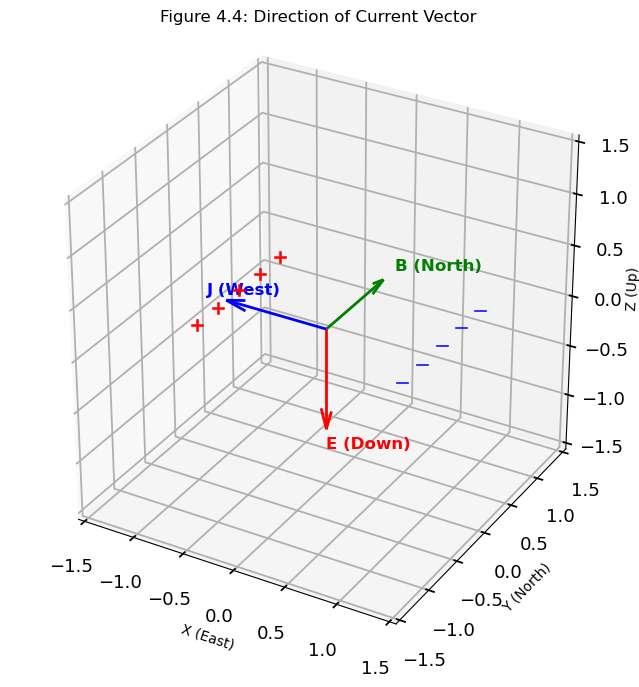

In [38]:
# ======== Plot Direction of Drift Velocity ========
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Define vectors
E = np.array([0, 0, -1])  # downward
B = np.array([0, 1, 0])   # northward
J = -np.cross(E, B)       # Current Density (westward for electrons)

# Function to plot vectors
def plot_vector(ax, vec, color, label):
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
              color=color, arrow_length_ratio=0.2, linewidth=2)
    ax.text(vec[0]*1.2, vec[1]*1.2, vec[2]*1.2, label,
            color=color, fontsize=12, weight='bold')

# Plot all vectors
plot_vector(ax, E, 'red', 'E (Down)')
plot_vector(ax, B, 'green', 'B (North)')
plot_vector(ax, J, 'blue', 'J (West)')

# Add multiple charges on east (negative) and west (positive)
for i in range(5):
    ax.scatter(1.0, -0.5 + i*0.35, 0, color='blue', s=100, marker='$-$')  # east side
    ax.scatter(-1.0, -0.5 + i*0.35, 0, color='red', s=100, marker='$+$')  # west side

# Axes settings
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
ax.set_xlabel('X (East)', labelpad = 10)
ax.set_ylabel('Y (North)', labelpad = 10)
ax.set_zlabel('Z (Up)', labelpad = 8)
ax.set_box_aspect([1,1,1])
ax.set_title("Figure 4.4: Direction of Current Vector", fontsize = 12)

plt.show()


- For emphasis, electrons are to the east, while positive charges are to the west, thus, current is directed westward.

- Owing to variation in conductivity (Hall) between day- and night-side of the terminator, this current flows in such a manner as to cause negative charges to accumulate at the terminator.

- The polarization of charges relative to the terminator causes the development of localized zonal electric field denoted by $E_L$, and oriented eastward. This is illustrated in Figure 4.5.

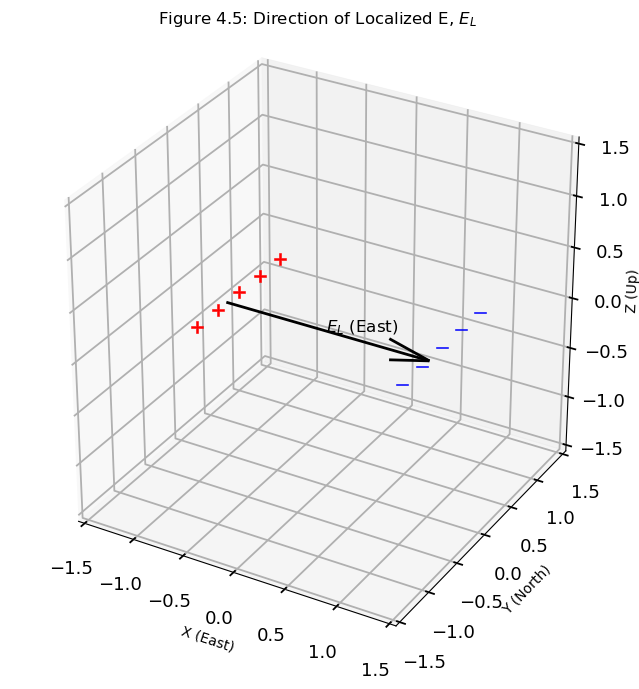

In [41]:
# ======== Plot Direction of Drift Velocity ========
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Define vectors
E = np.array([2, 0, 0])  # downward
B = np.array([0, 1, 0])   # northward
J = -np.cross(E, B)       # Current Density (westward for electrons)

# Function to plot vectors
def plot_vector(ax, vec, color, label):
    ax.quiver(-1, 0, 0, vec[0], vec[1], vec[2],
              color=color, arrow_length_ratio=0.2, linewidth=2)
    ax.text(vec[0]*0, vec[1]*1, vec[2]*1, label,
            color=color, fontsize=12)

# Plot all vectors
plot_vector(ax, E, 'black', '$E_L$ (East)')

# Add multiple charges on east (negative) and west (positive)
for i in range(5):
    ax.scatter(1.0, -0.5 + i*0.35, 0, color='blue', s=100, marker='$-$')  # east side
    ax.scatter(-1.0, -0.5 + i*0.35, 0, color='red', s=100, marker='$+$')  # west side

# Axes settings
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
ax.set_xlabel('X (East)', labelpad = 10)
ax.set_ylabel('Y (North)', labelpad = 10)
ax.set_zlabel('Z (Up)', labelpad = 8)
ax.set_box_aspect([1,1,1])
ax.set_title("Figure 4.5: Direction of Localized E, $E_L$", fontsize = 12)

plt.show()


- The integration of $\textbf{E}_L$ into the global zonal electric field, **E**, enhances the overall electric field to produce $\textbf{E}_{PRE}$. That is,

\begin{equation}
\textbf{E}_{PRE} \propto \textbf{E} + \textbf{E}_L
\end{equation}

- $\textbf{E}_{PRE}$ is also eastward. Hence, a cross between $\textbf{E}_{PRE}$ and magnetic field, **B**, results in a vertical drift stronger than the normal upward drift. This is the source of the **Pre-Reversal Enhancement** observed everyday, in every season and at all longitudinal sectors.
- Now, you know why the vertical drift on Figure 4.1 is enhanced after sunset.

#### References:
1. Eurico R. de Paula. (2021). Postgraduate Lecture notes on Space Geophysics [PowerPoint slides]. Instituto Nacional de Pesquisas Espaciais (INPE), Sao Jose dos Campos, Brazil.
2. Kelley, M. C. (2009). The Earth’s ionosphere: Plasma physics and electrodynamics (2nd ed.). Academic Press.